# Practical Introduction to Machine Learning

## Problem description

## Setup 🛠️

Install required librarires:

In [ ]:
%pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy     as np
import pandas    as pd

import datasets
from datasets import load_dataset

Load the dataset

In [ ]:
"""
  Reference:
    * Dataset card: https://huggingface.co/datasets/moroco
"""
moroco_dataset = load_dataset('moroco')
print(moroco_dataset)

  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'category', 'sample'],
        num_rows: 21719
    })
    test: Dataset({
        features: ['id', 'category', 'sample'],
        num_rows: 5924
    })
    validation: Dataset({
        features: ['id', 'category', 'sample'],
        num_rows: 5921
    })
})


In [ ]:
moroco_train_pd = pd.DataFrame(moroco_dataset['train'])
moroco_val_pd = pd.DataFrame(moroco_dataset['validation'])
moroco_test_pd = pd.DataFrame(moroco_dataset['test'])

In [ ]:
moroco_train_pd

,id,category,sample
0,48482,2,"“$NE$ cum am spus, nu este un sfârşit de drum ..."
1,36706,2,Liberal - democratul $NE$ $NE$ renunţă la mand...
2,21237,3,Cel mai puternic computer din lume nu e în $NE...
3,40719,4,Federaţia slovenă de fotbal ( $NE$ ) a anunţat...
4,49404,5,În cadrul unei întâlnirii a $NE$ de $NE$ din $...
...,...,...,...
21714,24709,4,O echipă de genişti a poliţiei braziliene a de...
21715,17783,3,"Pana sa ajunga la acest rezultat, cercetatorii..."
21716,35958,2,"$NE$ $NE$ în vârstă de 6 ani şi 11 luni, din c..."
21717,25754,2,Mai mulți demnitari de stat și politicieni au ...


In [ ]:
moroco_train_pd.describe(include="all")

,id,category,sample
count,21719,21719.000000,21719
unique,21719,NaN,21025
top,48482,NaN,$NE$ $NE$ $NE$ $NE$ $NE$ $NE$ $NE$ $NE$ $NE$ $...
freq,1,NaN,10
mean,NaN,2.471477,NaN
std,NaN,1.536043,NaN
min,NaN,0.000000,NaN
25%,NaN,1.000000,NaN
50%,NaN,2.000000,NaN
75%,NaN,4.000000,NaN


## Preprocessing our data

1) Obțineți reprezentările BOW pentru mulțimea de antrenare, validare și testare.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(moroco_train_pd["sample"][:8000])

train_data = vectorizer.transform(moroco_train_pd["sample"][:8000])
validation_data = vectorizer.transform(moroco_val_pd["sample"][:1000])
test_data = vectorizer.transform(moroco_test_pd["sample"][:2000])

In [ ]:
train_data

<8000x71600 sparse matrix of type '<class 'numpy.int64'>'
	with 1116880 stored elements in Compressed Sparse Row format>

2) Standardizați datele de antrenare, validare și testare folosind metoda de standardizare

***Standardizarea*** este procesul de transformare a vectorilor de caracteristici astfel încât fiecare vector să aibă medie 0 și deviația standard 1:

$$ x\_scaled = \frac{x - mean(x)}{\delta} $$

unde $x\_mean$ este media valorilor și $\delta$ este deviația standard.

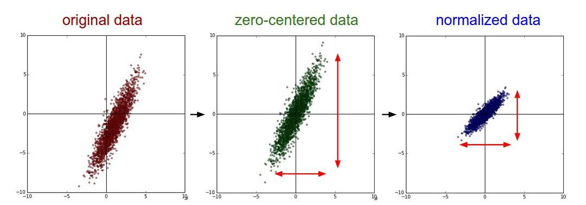

În partea stângă sunt reprezentate datele 2D originale. În mijloc sunt reprezentate datele centrate în origine, prin scăderea mediei pe fiecare dimensiune. În partea dreaptă, fiecare dimensiune este scalată folosind deviația standard corespunzătoare. Spre deosebire de imaginea din centru, unde datele au lungimi diferite pe cele două axe, aici ele sunt egale.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)

# calculam datele statistice pe setul de antrenare
scaler.fit(train_data)

# afisam media
print(scaler.mean_)
# afisam deviatia standard
print(scaler.scale_)

[1.10250e-01 2.15625e-01 1.25000e-04 ... 1.25000e-04 1.25000e-04
 1.25000e-04]
[1.06200044 1.09687322 0.01117964 ... 0.01117964 0.01117964 0.01117964]


In [ ]:
# scalam datele de antrenare
scaled_x_train = scaler.transform(train_data)
# scalam datele de validare
scaled_x_validation = scaler.transform(validation_data)
#scalam datele de testare
scaled_x_test = scaler.transform(test_data)

## Model selection

### Mașini cu vector suport

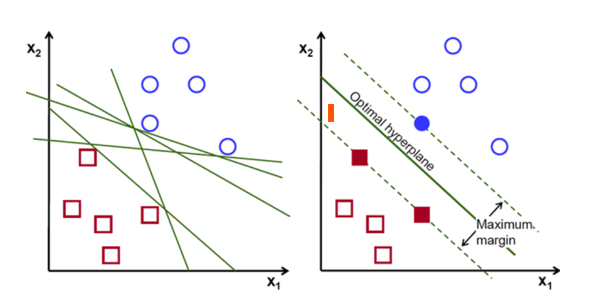

În partea stângă sunt prezentate drepte de decizie posibile pentru clasificarea celor două tipuri de obicete. SVM-ul, exemplificat în partea dreaptă, alexe hiperplanul care maximizează marginea dintre cele două clase.

### Detalii de implementare

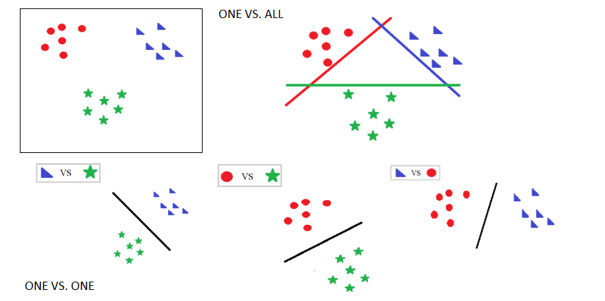

Există două tipuri de abordări pentru a clasifica datele aparținând mai multor clase:


1.   **ONE VS ALL:** Sunt antrenați $n$ clasificatori, câte unul corespunzător fiecărei clase, care să diferențieze pe aceasta de toate celelalte (toate celelalte exemple sunt privite ca aparținând aceleiași clase). Eticheta finală pentru un exemplu nou va fi dată de clasificatorul care a obținut scorul maxim.
2.   **ONE VS ONE:** Sunt antrenați $\frac{n * (n - 1)}{2}$ clasificstori, câte unul corespunzător fiecărei perechi de câte două clase. Eticheta finală pentru un exemplu nou va fi cea care obține cele mai multe voturi pe baza acestor clasificatori



### Alegerea parametrilor

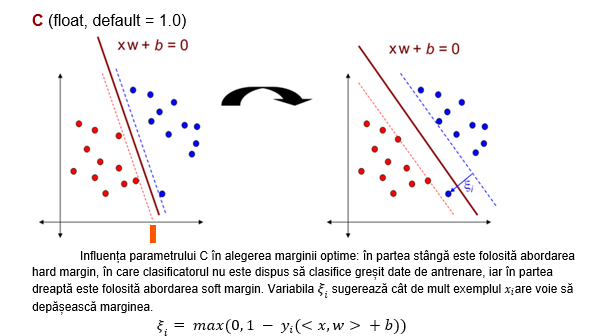

**C** reprezintă un parametru de penalitate pentru eroare, sugerează cât de mult este dispus modelul să evite clasificarea greșită a exemplelor din setul de antrenare:

*   *C mare* - va fi ales un hiperplan cu o margine mai mică, dacă acesta are rezultate mai bune pe setul de antrenare => dacă C va fi ales prea mare, se poate ajunge la "overfitting"
*   *C mic* - va fi ales un hiperplan cu o margine mai mare, chiar dacă acesta duce la o clasificare greșită a câtorva puncte din setul de antrenare => dacă C va fi ales prea mic, modelul nu va fi capabil să învețe, ceea ce conduce la "underfitting" 



3.1) Definiți funcția svm_classifier(train_data, train_labels, test_data, C) care primește ca parametru datele de antrenare, respectiv datele de testare și parametrul C. Aceasta antrenează un SVM linear classifier și returnează predicțiile obținute pe setul de antrenare, respectiv testare

In [ ]:
from sklearn import svm

def svm_classifier(train_data, train_labels, test_data, c):
  linear_svm_classifier = svm.SVC(C=c, kernel='linear')
  linear_svm_classifier.fit(train_data, train_labels)
  predicted_labels_train = linear_svm_classifier.predict(train_data)
  predicted_labels_test = linear_svm_classifier.predict(test_data)

  return predicted_labels_train, predicted_labels_test

3.2) Antrenați un SVM cu kernel linear care să clasifice documentele în topicele precizate anterior. Pentru paramterul C setați valoarea 1. Calculați acuratețea.

In [ ]:
def compute_accuray(gt_labels, predicted_labels):
  accuracy = np.sum(predicted_labels == gt_labels) / len(predicted_labels)
  return accuracy

In [ ]:
# train + predict
predicted_labels_train, predicted_labels_test = svm_classifier(scaled_x_train, moroco_train_pd["category"][:8000], \
                                                               scaled_x_test, \
                                                               1)
print("Accuracy: ", compute_accuray(moroco_test_pd["category"][:2000], predicted_labels_test))

Accuracy:  0.69


## Optimization

4) Folosinf funcția definită la exercițiul 3) calculați acuratețea pe mulțimile de antrenare și validare pentru următoarele valori ale parametrului C: [1e-2, 1, 10, 100]. Plotați rezultatele folosind pe axa Ox $ log_{10}(C) $, iar pe Oy acuratețea. 

Accuracy train:  0.2715
Accuracy validation:  0.277
Accuracy train:  0.990125
Accuracy validation:  0.685
Accuracy train:  0.990125
Accuracy validation:  0.689


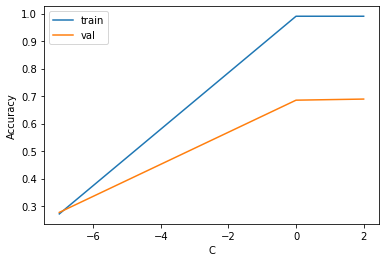

In [ ]:
import matplotlib.pyplot as plt

accuracies_train, accuracies_val = [], []
Cs = [1e-7, 1., 100.]

for C in Cs:
  predicted_labels_train, predicted_labels_val = svm_classifier(scaled_x_train, moroco_train_pd["category"][:8000], \
                                                               scaled_x_validation, \
                                                               C)
  
  accuracy_train = compute_accuray(moroco_train_pd["category"][:8000], predicted_labels_train)
  accuracy_val = compute_accuray(moroco_val_pd["category"][:1000], predicted_labels_val)
  accuracies_train.append(accuracy_train)
  accuracies_val.append(accuracy_val)

  print("Accuracy train: ", accuracy_train)
  print("Accuracy validation: ", accuracy_val)


plt.plot(np.log10(Cs), accuracies_train)
plt.plot(np.log10(Cs), accuracies_val)
plt.legend(["train", "val"])
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.show()